In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.stats.qmc import LatinHypercube
import plotly.graph_objects as go

### Varying sigmoid parameters for global density on varying mean distance

In [3]:
def compute_distances(x: np.ndarray, dataset_points: np.ndarray) -> np.ndarray:
    x = np.atleast_2d(x)
    return distance.cdist(x, dataset_points, metric="euclidean")


def sigmoid(x: np.ndarray, pos: float, speed: float, increasing: bool) -> np.ndarray:
    if increasing:
        return 1 / (1 + np.exp(-(x - pos) * speed))
    else:
        return 1 / (1 + np.exp((x - pos) * speed))

In [4]:
# Parameters
n_features = 3  # Number of dimensions (features) for each point
n_total_points = 300  # Total number of points
n_sphere_points = 100  # Number of points in the moving sphere
n_fix_points = n_total_points - n_sphere_points  # Number of fixed points

# Generate radii for moving points
# These points are assumed to move from the center (0.5, 0.5, ..., 0.5) to a maximum radius of 1/2
radii = np.linspace(0, 1, 500) * 0.5

# Generate fixed points randomly distributed in the space
# These points are distributed throughout the space and do not move
fix_points = LatinHypercube(d=n_features).random(n=n_fix_points)
fix_std = fix_points.std()

# Compute distances from a central point (0.5, 0.5, ..., 0.5) to the fixed points
# The central point represents a point at the center of the space
fix_distances = compute_distances(
    x=np.array([[0.5] * n_features]),
    dataset_points=fix_points
)

In [5]:
mean_dist = 1/n_total_points * (n_sphere_points * radii + np.sum(fix_distances))

# Determine sigmoid parameters based on actual means.
overfit_pos = np.median(mean_dist)
overfit_speed = 10 / np.std(mean_dist) if np.std(mean_dist) != 0 else 1

# Define sigmoid configurations
sigmoid_configs = [
    # {'pos': 1/4, 'speed': 20},
    # {'pos': fix_std, 'speed': n_total_points},
    {'pos': fix_std, 'speed': 1/ 10 * n_total_points},
    {'pos': overfit_pos, 'speed': overfit_speed},
]

# Compute sigmoid variation for each configuration
y_sigmoid = [sigmoid(mean_dist, **config, increasing=False) for config in sigmoid_configs]

# Create a plot using Plotly
fig = go.Figure()

# Add a line for each sigmoid configuration
for i, y_values in enumerate(y_sigmoid):
    config = sigmoid_configs[i]
    fig.add_trace(go.Scatter(
        x=radii, 
        y=y_values, 
        mode='lines', 
        name=f"pos={config['pos']:.2f}_speed={config['speed']:.2f}"
    ))

fig.add_vline(
    x=fix_std, 
    line_width=1, line_dash="dash", line_color="red", 
    annotation_text='std', annotation_position="top right"
)

# Update layout for better visualization
fig.update_layout(
    title=f'Global density = decreasing_sigmoid(mean(distances)) with {n_fix_points} fix points and {n_sphere_points} surrounding points on sphere with a varying radius',
    xaxis_title='Mean Distance',
    yaxis_title='Global density',
    legend_title='Sigmoid Configurations'
)

# Show plot
fig.show()

In [6]:
# Compute mean of distances
max_dist = np.sqrt(n_features)  # Hypercube diagonal
mean_dist = 1/n_total_points * (n_sphere_points * radii + np.sum(fix_distances))

# Create a plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=radii,
    y=mean_dist,
    mode='lines',
    name='mean distances'
))

# Update layout for better visualization
fig.update_layout(
    title=f'Global density = mean(distances) with {n_fix_points} fix points and {n_sphere_points} surrounding points on sphere with a varying radius',
    xaxis_title='Mean Distance',
    yaxis_title='Global density',
    legend_title='Std Value'
)

# Show plot
fig.show()
    

### Varying sigmoid parameters for local density on varying mean distance

In [7]:
# Characteristic qtt
std_decay = 0.1*fix_points.std()
avg_combined_score = (
    n_sphere_points * np.exp(-1)
    + np.sum(np.exp(-fix_distances / std_decay))
)

# Define sigmoid configurations
sigmoid_configs = [
    {'pos': 5,  'speed': 1,   'decay': 0.04},
    {'pos': 5,  'speed': 1,   'decay': 0.1 * fix_points.std()},
    {'pos': avg_combined_score,  'speed': 1,   'decay': 0.1*fix_points.std()},
]

# Compute variation of cumulated scores reduced with a sigmoid for each configuration
y_sigmoid = []
for config in sigmoid_configs:
    combined_scores = (
        n_sphere_points * np.exp(-radii / config['decay'])
        + np.sum(np.exp(-fix_distances / config['decay']))
    )
    
    y_sigmoid.append(sigmoid(combined_scores, config['pos'], config['speed'], increasing=True))

# Create a plot using Plotly
fig = go.Figure()

# Add a line for each sigmoid configuration
for i, y_values in enumerate(y_sigmoid):
    config = sigmoid_configs[i]
    fig.add_trace(go.Scatter(
        x=radii, 
        y=y_values, 
        mode='lines', 
        name=f"decay={config['decay']:.2f}_pos={config['pos']:.2f}_speed={config['speed']:.2f}"
    ))
fig.add_vline(
    x=fix_points.std(), 
    line_width=1, line_dash="dash", line_color="red", 
    annotation_text='std', annotation_position="top right"
)
fig.add_vline(
    x=0.1*fix_points.std(), 
    line_width=1, line_dash="dash", line_color="red", 
    annotation_text='0.1*std', annotation_position="top right"
)

# Update layout for better visualization
fig.update_layout(
    title=f'Local Density reduced with sigmoid with {n_fix_points} fix points and {n_sphere_points} surrounding points on sphere with a varying radius',
    xaxis_title='Radius',
    yaxis_title='Sigmoid Value',
    legend_title='Sigmoid Configurations'
)

# Show plot
fig.show()

The sigmoid does a good job to enable the use of cumulated scores.

In [8]:
# Define sigmoid configurations
local_std_configs = [
    {'decay_dist': 0.05},
    {'decay_dist': 0.1},
    {'decay_dist': 0.5},
    {'decay_dist': fix_points.std()},
    {'decay_dist': 0.1*fix_points.std()},
    # Add more configurations as needed
]

# Compute mean score variation for each configuration
y_local_density = [
    1/n_total_points * (
        n_sphere_points * np.exp(-radii / config['decay_dist'])
        + np.sum(np.exp(-fix_distances / config['decay_dist']))
    ) 
    for config in local_std_configs
]

# Create a plot using Plotly
fig = go.Figure()

# Add a line for each sigmoid configuration
for i, y_values in enumerate(y_local_density):
    config = local_std_configs[i]
    fig.add_trace(go.Scatter(
        x=radii, 
        y=y_values, 
        mode='lines', 
        name=f"{config['decay_dist']:.2f}"
    ))
fig.add_vline(
    x=fix_points.std(), 
    line_width=1, line_dash="dash", line_color="red", 
    annotation_text='std', annotation_position="top right"
)

# Update layout for better visualization
fig.update_layout(
    title=f'Local Density reduced with sigmoid with {n_fix_points} fix points and {n_sphere_points} surrounding points on sphere with a varying radius',
    xaxis_title='Radius',
    yaxis_title='Local Density Value',
    legend_title='Decay dist'
)

# Show plot
fig.show()

### Focus on decay effect

In [9]:
# Generate mean distance values from 0 to max_dist
max_dist = np.sqrt(n_features)  # Hypercube diagonal
random_mean_dist = np.sqrt(n_features/6)
mean_dist = np.linspace(0, max_dist, 500)

# Define decay distances
decay_dist_values = np.linspace(0.01, 0.2, 5)  # 5 values from 0.01 to 0.2

# Create a plot using Plotly
fig = go.Figure()

# Compute and plot decay scores for each decay_dist
for decay_dist in decay_dist_values:
    decay_scores = np.exp(-mean_dist / decay_dist)
    fig.add_trace(go.Scatter(
        x=mean_dist,
        y=decay_scores,
        mode='lines',
        name=f"decay_dist={decay_dist:.2f}"
    ))
fig.add_vline(random_mean_dist, line_width=1)

# Update layout for better visualization
fig.update_layout(
    title='Decay Scores for Various Decay Distances',
    xaxis_title='Mean Distance',
    yaxis_title='Decay Score',
    legend_title='Decay Distance'
)

# Show plot
fig.show()

## Conclusion

Identifying appropriate parameters for sigmoid functions, such as position and speed, or determining a decay distance suitable for all configurations, is challenging. The concept of a global density, computed as the mean of all pairwise distances without considering decay, is not particularly useful for the figure of merit. This approach tends to move away from the densest regions, even when empty regions are nearby. Therefore, local density emerges as a more relevant metric.

However, the use of sigmoid functions can diminish the effect of decay smoothness. Also, setting the parameters for sigmoid functions is particularly challenging, as they are often determined empirically. A direct sum of decay scores provides a smoother and more manageable approach.

GP uses a similar approach based on its kernel to measure the contribution (covariance) of known target values. GP adaptively fits the decay distance to the data, determining an appropriate decay for the current dataset. Additionally, GP leverages the inverse of the covariance matrix to weight points before performing a weighted sum using decay functions.  It ensures that the prediction incorporates the similarity between data points. Consequently, using a uniform decay distance across different datasets is not feasible. A direct sum does not yield satisfactory results, and using the mean diminishes the influence of close neighbors when the dataset is large.

These challenges must be addressed to develop a coherent local density measure based on kernel functions.

## Computing density for a theoretical dataset

In [10]:
def generate_points_2d(n_total):
    # Total number of points
    n_per_quadrant = int(n_total / 4)
    n_sparse = int(n_per_quadrant / 4)
    n_dense = 2*n_per_quadrant - n_sparse + n_total % 4

    # Upper left quadrant: uniformly random
    upper_left_x = np.random.uniform(low=0, high=0.5, size=n_per_quadrant)
    upper_left_y = np.random.uniform(low=0.5, high=1, size=n_per_quadrant)
    upper_left = np.column_stack((upper_left_x, upper_left_y))

    # Upper right quadrant: uniformly random but only extreme upper right
    upper_right = np.random.uniform(low=0.8, high=1, size=(n_per_quadrant, 2))

    # Lower left quadrant: very dense uniformly random
    lower_left = np.random.uniform(low=0, high=0.5, size=(n_dense, 2))

    # Lower right quadrant: very sparse uniformly random
    lower_right_x = np.random.uniform(low=0.5, high=1, size=n_sparse)
    lower_right_y = np.random.uniform(low=0, high=0.5, size=n_sparse)
    lower_right = np.column_stack((lower_right_x, lower_right_y))

    # Combine all quadrants
    X = np.vstack((upper_left, upper_right, lower_left, lower_right))

    return X

# Generate 2D points
dataset_points_th = generate_points_2d(300)
batch_points_th = np.array([[0.25, 0.75], [0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.9, 0.9]])

# Compute distances
distances_th = compute_distances(batch_points_th, dataset_points_th)
std_th = dataset_points_th.std()
print(f'std_th: {std_th}')

std_th: 0.32513516688788224


In [11]:
# Visualization for 2D
fig = go.Figure()

# Add the points
fig.add_trace(go.Scatter(
    x=dataset_points_th[:, 0], 
    y=dataset_points_th[:, 1], 
    mode='markers', 
    marker=dict(color='blue', size=3),
    name='Dataset points'
))
fig.add_trace(go.Scatter(
    x=batch_points_th[:, 0], 
    y=batch_points_th[:, 1], 
    mode='markers+text', 
    text=[str(i + 1) for i in range(len(batch_points_th))],  # Add numbers from 1 to n
    textposition='top right',  # Position the text next to the points
    marker=dict(color='red', size=5),
    name='Batch points'
))

# Add vertical and horizontal lines to split the plane into 4 equal squares
fig.add_hline(0.5, line_width=1)
fig.add_vline(0.5, line_width=1)

# Update the layout
fig.update_layout(
    title='A theoretical dataset with heterogeneous distribution',
    xaxis_title='X',
    yaxis_title='Y',
    showlegend=False,
    width=800,
    height=800
)

# Show the plot
fig.show()

You can consider here that blue scatter is the dataset points and red ones are the batch selected candidates.

In [12]:
def compute_sigmoid_global_density(distances: np.ndarray, sigmoid_pos: float, sigmoid_speed: float) -> np.ndarray:
    mean_distances = distances.mean(axis=1)
    global_scores = sigmoid(mean_distances, sigmoid_pos, sigmoid_speed, increasing=False)
    return global_scores

def compute_global_density(distances: np.ndarray, norm_factor: float) -> np.ndarray:
    mean_distances = distances.mean(axis=1)
    return mean_distances/norm_factor

def compute_sigmoid_local_density(distances: np.ndarray, decay_dist: float, sigmoid_pos: float, sigmoid_speed: float) -> np.ndarray:
    decay_scores = np.exp(-distances / decay_dist)
    combined_scores = decay_scores.sum(axis=1)
    transformed_decays = sigmoid(combined_scores, sigmoid_pos, sigmoid_speed, increasing=True)
    return transformed_decays

def compute_local_density(distances: np.ndarray, decay_dist: float) -> np.ndarray:
    decay_scores = np.exp(-distances / decay_dist)
    return decay_scores.mean(axis=1)

In [13]:
def compute_sigmoid_global_densities(distances: np.ndarray, configs: list) -> pd.DataFrame:
    global_density_results = {}

    # Compute global densities for each configuration
    for config in configs:
        pos = config['pos']
        speed = config['speed']
        
        # Compute global density
        global_key = f"pos={pos:.2f}_speed={speed:.2f}"
        global_density_results[global_key] = compute_sigmoid_global_density(distances, sigmoid_pos=pos, sigmoid_speed=speed)

    # Convert results to a DataFrame
    global_density_df = pd.DataFrame(global_density_results, index=range(1, distances.shape[0]+1))
    
    return global_density_df


def compute_global_densities(distances: np.ndarray, configs: list) -> pd.DataFrame:
    global_density_results = {}

    # Compute global densities for each configuration
    for config in configs:
        norm_factor = config['norm_factor']
        
        # Compute global density
        global_key = f"norm={norm_factor:.2f}"
        global_density_results[global_key] = compute_global_density(distances, norm_factor)

    # Convert results to a DataFrame
    global_density_df = pd.DataFrame(global_density_results, index=range(1, distances.shape[0]+1))
    
    return global_density_df

In [14]:
def compute_sigmoid_local_densities(distances: np.ndarray, configs: list) -> pd.DataFrame:
    local_density_results = {}

    # Compute local densities for each configuration
    for config in configs:
        decay_dist = config['decay_dist']
        pos = config['pos']
        speed = config['speed']
        
        # Compute local density
        local_key = f"decay={decay_dist:.2f}_pos={pos:.2f}_speed={speed:.2f}"
        local_density_results[local_key] = compute_sigmoid_local_density(distances, decay_dist, pos, speed)

    # Convert results to a DataFrame
    local_density_df = pd.DataFrame(local_density_results, index=range(1, distances.shape[0]+1))
    
    return local_density_df


def compute_local_densities(distances: np.ndarray, configs: list) -> pd.DataFrame:
    local_density_results = {}

    # Compute local densities for each configuration
    for config in configs:
        decay_dist = config['decay_dist']
        
        # Compute local density
        local_key = f"decay={decay_dist:.2f}"
        local_density_results[local_key] = compute_local_density(distances, decay_dist)

    # Convert results to a DataFrame
    local_density_df = pd.DataFrame(local_density_results, index=range(1, distances.shape[0]+1))
    
    return local_density_df

In [15]:
# Set for each batch point mean distance to every dataset point 
mean_distances_th = distances_th.mean(axis=1)

# Determine sigmoid parameters based on actual means.
overfit_means_center_th = np.median(mean_distances_th)
overfit_means_inverse_std_th = 10 / np.std(mean_distances_th) if np.std(mean_distances_th) != 0 else 1

global_sigmoid_configs = [
    {'pos': 5, 'speed': 1},
    {'pos': 5, 'speed': 2},
    # {'pos': 2, 'speed': 3},
    {'pos': overfit_means_center_th, 'speed': overfit_means_inverse_std_th},
    # Add more configurations as needed
]
sigmoid_global_density_df = compute_sigmoid_global_densities(distances_th, global_sigmoid_configs)


global_std_configs = [
    {'norm_factor': std_th},
    {'norm_factor': 0.5*std_th},
    {'norm_factor': 0.1*std_th},
    {'norm_factor': overfit_means_center_th},
    # Add more configurations as needed
]
global_density_df = compute_global_densities(distances_th, global_std_configs)

In [16]:
# Compute for each batch point the sum of decay effects of dataset points
decay_dist_th = 0.04
combined_decays_th = np.exp(-distances_th / decay_dist_th).sum(axis=1)

# Determine sigmoid parameters based on actual decay scores
overfit_decays_center_th = np.median(combined_decays_th)
overfit_decays_inverse_std_th = (1 / np.std(combined_decays_th)) if np.std(combined_decays_th) != 0 else 1

local_sigmoid_configs = [
    {'pos': 5, 'speed': 1, 'decay_dist':decay_dist_th},
    {'pos': 5, 'speed': 1, 'decay_dist': 0.1 * std_th},
    {'pos': overfit_decays_center_th, 'speed': overfit_decays_inverse_std_th, 'decay_dist': decay_dist_th},
    # Add more configurations as needed
]
sigmoid_local_density_df = compute_sigmoid_local_densities(distances_th, local_sigmoid_configs)


local_std_configs = [
    {'decay_dist': 0.04},
    {'decay_dist': 0.1*std_th},
    {'decay_dist': 0.5*std_th},
    {'decay_dist': std_th},
    # Add more configurations as needed
]
local_density_df = compute_local_densities(distances_th, local_std_configs)

In [17]:
print(f'sigmoid_global_density_df: \n{sigmoid_global_density_df}')
print('\n')
print(f'sigmoid_local_density_df for decay={decay_dist_th}: \n{sigmoid_local_density_df}')

sigmoid_global_density_df: 
   pos=5.00_speed=1.00  pos=5.00_speed=2.00  pos=0.54_speed=160.74
1             0.989002             0.999876           9.982995e-01
2             0.989300             0.999883           9.999804e-01
3             0.988007             0.999853           4.470559e-04
4             0.988562             0.999866           5.000000e-01
5             0.987291             0.999834           3.564682e-08


sigmoid_local_density_df for decay=0.04: 
   decay=0.04_pos=5.00_speed=1.00  decay=0.03_pos=5.00_speed=1.00  \
1                        0.104422                        0.046740   
2                        0.820038                        0.362203   
3                        0.014348                        0.010544   
4                        0.018963                        0.010910   
5                        0.999930                        0.996399   

   decay=0.04_pos=2.85_speed=0.19  
1                        0.500000  
2                        0.671361  
3  

In [18]:
print(f'global_density_df: \n{global_density_df}')
print('\n')
print(f'local_density_df: \n{local_density_df}')

global_density_df: 
   norm=0.33  norm=0.16  norm=0.03  norm=0.54
1   1.540954   3.081908  15.409539   0.926645
2   1.455553   2.911105  14.555525   0.875289
3   1.810513   3.621027  18.105134   1.088743
4   1.662940   3.325879  16.629396   1.000000
5   1.991092   3.982183  19.910917   1.197333


local_density_df: 
   decay=0.04  decay=0.03  decay=0.16  decay=0.33
1    0.009503    0.006616    0.110058    0.269468
2    0.021722    0.014781    0.176101    0.339065
3    0.002568    0.001528    0.054042    0.192089
4    0.003513    0.001643    0.097167    0.250759
5    0.048533    0.035410    0.168941    0.268285


In [19]:
print(f'mean_distances_th: \n{pd.DataFrame(mean_distances_th)}')
print(f'combined_decays_th: \n{pd.DataFrame(combined_decays_th)}')
print(f'dataset_points_th.std : {dataset_points_th.std()}')
print(f'mean_distances_th.mean : {np.mean(mean_distances_th)}')
print(f'mean_distances_th.median : {np.median(mean_distances_th)}')

mean_distances_th: 
          0
0  0.501018
1  0.473251
2  0.588662
3  0.540680
4  0.647374
combined_decays_th: 
           0
0   2.850975
1   6.516604
2   0.770306
3   1.053881
4  14.559861
dataset_points_th.std : 0.32513516688788224
mean_distances_th.mean : 0.5501970527722407
mean_distances_th.median : 0.5406801297702581


# Some important things to now about std

In [20]:
from scipy.spatial.distance import cdist, pdist
from scipy.stats import qmc
import numpy as np

# Generate random samples in [0, 1]^p hypercube
n, p = 1000, 3
# points = np.random.rand(n, p)  # Using independent uniform selection along each axis
points = qmc.LatinHypercube(p).random(n)  # Using a comprehensive sampling method

# Compute sum of columns standard deviations
std = points.std()

# Compute standard deviation of points in the space
center = np.mean(points, axis=0)
distances_to_center = cdist(points, center.reshape(1, -1), metric="euclidean")
# distances_to_center = np.linalg.norm(points - center, axis=1)  # Also works
eucl_std = np.sqrt(np.mean(distances_to_center**2))

# Compute pairwise distances RMS
pairwise_distances = pdist(points, metric="euclidean")
pdist_rms = np.sqrt(np.mean(pairwise_distances**2))

print(f'points.shape: {points.shape}')
print(f'pairwise_distances.shape: {pairwise_distances.shape}')
print(f'Number of combinations n(n-1)/2: {int(n*(n-1)/2)}')
print()
print(f'data std per dimension sum: {std:.3f}')
print(f'data euclidian std: {eucl_std:.3f}')
print(f'pdist rms: {pdist_rms:.3f}')
print(f'sqrt(2n/(n-1)) * std : {np.sqrt(2*n / (n-1)) * eucl_std:.3f}')

points.shape: (1000, 3)
pairwise_distances.shape: (499500,)
Number of combinations n(n-1)/2: 499500

data std per dimension sum: 0.289
data euclidian std: 0.500
pdist rms: 0.707
sqrt(2n/(n-1)) * std : 0.707


Note on Standard Deviation Calculations:

The default standard deviation calculation in NumPy computes the standard deviation for each column independently and returns a single value representing the spread of all values in the dataset. However, when we want a true spatial standard deviation, we must compute it using the root mean square (RMS) of the Euclidean distances from each point to the center (mean) of the dataset. This approach provides a measure that is directly related to the RMS of pairwise distances.

# Mathematical Relation Between Standard Deviation and Mean of Pairwise Distances

## 1. Standard Deviation (`dataset_points.std()`)

- **Definition**: The standard deviation is a measure of the dispersion or spread of a set of values around their mean.

- **Formula**: For a dataset with values $( x_1, x_2, ..., x_n )$, the standard deviation $\sigma$ is calculated as:
  $$
  \sigma = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \|x_i - \mu\|^2}
  $$
  where \( \mu \) is the mean of the dataset.

## 2. Mean of Pairwise Distances (`pairwise_distances.mean()`)

- **Definition**: The mean of pairwise distances is the average of all distances between each pair of points in a dataset.
  
- **Formula**: For a dataset with points $( x_1, x_2, ..., x_n )$, pairwise distances vector is $D_k = \left( \|x_j - x_i\| \right)_{1 \leq i < j \leq n}$ composed of $\binom{n}{2} = \frac{n(n-1)}{2}$ elements.

The mean can be calculated as:
  $$
  \text{E}(D_k) = \frac{2}{n(n-1)} \sum_{i < j} \|x_i - x_j\| = \frac{1}{n(n-1)} \sum_{i \neq j} \|x_i - x_j\|
  $$
  Or using the root mean square (RMS):
  $$
  \text{RMS}(D_k) = \sqrt{\frac{1}{n(n-1)} \sum_{i \neq j} \|x_i - x_j\|^2}
  $$

## 3. Mathematical difference
We can prove that:
  $$
  \sum_{i \neq j} \|x_i - x_j\|^2 = \sum_{i \neq j} \|(x_i - \mu) - (x_j - \mu)\|^2 = 2n \sum_{i=1}^{n} \|x_i - \mu\|^2
  $$
Thus:
  $$
  \text{RMS}(D_k) = \sqrt{\frac{2n}{n-1}} \centerdot \sigma
  $$

# Local Density Optimal Length Scale

Consider a dataset of $n$ points in a $p$-dimensional space. We define a local density score $D$ for a sample $x^*$ based on the sum of Radial Basis Function (RBF) kernel values with respect to each point $x_i$ in the dataset:

$$
D(x^*) = \sum_{i=1}^{n} k(x^*, x_i)
$$


where $ k(x, x_i) = \exp\left(-\frac{\|x - x_i\|^2}{2\ell^2}\right) $ is the RBF kernel with length scale $\ell$.

To find the optimal length scale $\ell$, we aim to minimize the following objective:

$$
\text{Objective} = \left| D_{\max} - 1 \right| + D_{\min}
$$


where

$$
D_{\max} = \max_{x \in S_{\text{MC}}} \left( \sum_{i=1}^{n} k(x, x_i) \right)
$$


and

$$
D_{\min} = \min_{x \in S_{\text{MC}}} \left( \sum_{i=1}^{n} k(x, x_i) \right)
$$


Here, $ S_{\text{MC}} $ represents a set of Monte Carlo samples.

# Compute density using KDE

In [21]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import RandomizedSearchCV

# Generate synthetic dataset with n samples and p dimensions
n, p = 100, 2  # Example: 100 samples, 2 dimensions
np.random.seed(0)
data = np.random.randn(n, p)
print(f"data description: \n{pd.DataFrame(data).describe()}")

# Define a range of bandwidths to search over
bandwidths = np.logspace(-5, 0, 100)

# Use RandomizedSearchCV to find the best bandwidth
random_search = RandomizedSearchCV(
    KernelDensity(kernel='gaussian'),
    {'bandwidth': bandwidths},
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    random_state=0
)
random_search.fit(data)

# Get the best bandwidth
best_bandwidth = random_search.best_params_['bandwidth']
print(f"Optimal bandwidth: {best_bandwidth}")

# Fit KDE with the best bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
kde.fit(data)


data description: 
                0           1
count  100.000000  100.000000
mean    -0.000958    0.142779
std      1.027106    1.020933
min     -2.552990   -2.223403
25%     -0.805844   -0.596894
50%     -0.053762    0.142666
75%      0.737077    0.858479
max      2.383145    2.240893
Optimal bandwidth: 0.44306214575838776


KernelDensity(bandwidth=0.44306214575838776)

In [22]:

# Evaluate the density on a grid of points
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T
log_grid_density = kde.score_samples(grid_points)
grid_density = np.exp(log_grid_density)
max_grid_density = np.max(grid_density)

# Evaluate the density on dataset points
data_log_density = kde.score_samples(data)
data_density = np.exp(data_log_density)
max_data_density = np.max(data_density)

# Use MeanShift to find maximum density
from sklearn.cluster import MeanShift
mean_shift = MeanShift(bandwidth=best_bandwidth)
mean_shift.fit(data)

# Get the mode (highest density point)
modes = mean_shift.cluster_centers_

# Compute the maximum density at the mode
log_modes_density = kde.score_samples(modes)
modes_density = np.exp(log_modes_density)
max_mode_density = np.max(modes_density)

# Check if there is any point with density close to 0.5
threshold = 0.5
close_to_threshold = np.any(np.isclose(grid_density, threshold, atol=0.01))

print(f"Is there a point with density close to {threshold}? {close_to_threshold}.")
print(f"Highest grid density: {max_grid_density:.3f}")
print(f"Highest data density: {max_data_density:.3f}")
print(f"Highest mode density: {max_mode_density:.3f}")


Is there a point with density close to 0.5? False.
Highest grid density: 0.119
Highest data density: 0.118
Highest mode density: 0.118


In [23]:
print(mean_shift.cluster_centers_.shape)

(26, 2)


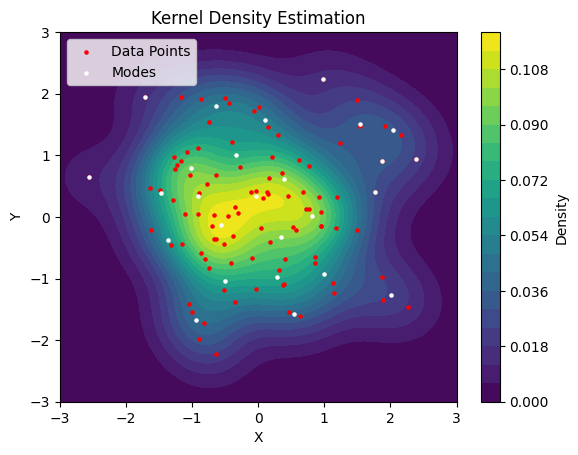

In [24]:
# Plot the density
import matplotlib.pyplot as plt
plt.contourf(X, Y, grid_density.reshape(X.shape), levels=20, cmap='viridis')
plt.colorbar(label='Density')
plt.scatter(data[:, 0], data[:, 1], c='red', s=5, label='Data Points')
plt.scatter(modes[:, 0], modes[:, 1], c='white', s=5, label='Modes')
plt.title('Kernel Density Estimation')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()